In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from scipy.misc import imresize
import matplotlib.pyplot as plt
%matplotlib inline

# fix random seed for reproducibility
np.random.seed(7)

# Load MNIST dataset
from keras.datasets import mnist
(Xtrain, Ytrain), (Xtest, Ytest) = mnist.load_data()

(ntrain, xdim, ydim) = Xtrain.shape
ntest = Xtest.shape[0]

# split train data in two
X_pr = Xtrain[30000:60000, :, :]
Y_pr = Ytrain[30000:60000]

Xtrain = Xtrain[0:30000, :, :];
Ytrain = Ytrain[0:30000]


Using TensorFlow backend.


In [3]:
# *** DOWNSAMPLE THE IMAGES ***
factor = 0.25

Xtrain_down = np.ones((Xtrain.shape[0], int(xdim*factor), int(ydim*factor)))
for i in range(Xtrain.shape[0]):
    Xtrain_down[i, :, :] = imresize(Xtrain[i,:,:], factor)

Xtest_down = np.ones((Xtest.shape[0], int(xdim*factor), int(ydim*factor)))
for i in range(Xtest.shape[0]):
    Xtest_down[i,:,:] = imresize(Xtest[i,:,:], factor)

    
X_pr_down = np.ones((X_pr.shape[0], int(xdim*factor), int(ydim*factor)))
for i in range(X_pr.shape[0]):
    X_pr_down[i,:,:] = imresize(X_pr[i,:,:], factor)

In [13]:
# *** VECTORIZE IMAGES ***
Xtrain_down = Xtrain_down.reshape(Xtrain.shape[0], int(xdim*factor)**2).astype('float32') / 255
Xtest_down  = Xtest_down.reshape(ntest, int(xdim*factor)**2).astype('float32') / 255
X_pr_down   = X_pr_down.reshape(X_pr.shape[0], int(xdim*factor)**2).astype('float32') / 255
Xtrain      = Xtrain.reshape(Xtrain.shape[0], xdim**2).astype('float32') / 255
Xtest       = Xtest.reshape(ntest, xdim**2).astype('float32') / 255
# Categorical labels
Ytrain = np_utils.to_categorical(Ytrain, 10)
Ytest = np_utils.to_categorical(Ytest, 10)


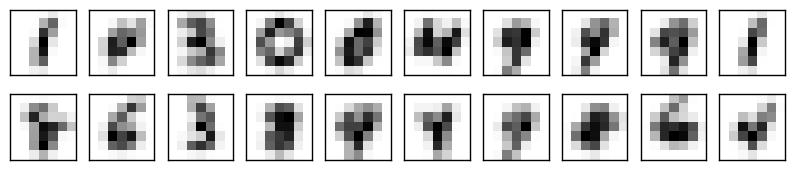

In [7]:
# *** VISUALIZATION 20 RANDOM TRAINING SAMPLES ***
# Create 20 subplots
fig, axes = plt.subplots(2, 10, figsize=(10, 2))

for i in range(2):
    for j in range(10):
        axes[i][j].imshow(Xtrain_down[np.random.randint(0, 3000),:].reshape(int(xdim*factor), 
                          int(ydim*factor)), cmap='gray_r', interpolation='nearest')
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
        

In [8]:
# # *** LDA ***
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# # Original images
# clf = LinearDiscriminantAnalysis()
# clf.fit(Xtrain, Ytrain)
# LinearDiscriminantAnalysis(n_components=9, priors=None, shrinkage=None,
#               solver='svd', store_covariance=False, tol=0.0001)

# # Returns the mean accuracy on the given test data and labels.
# score = clf.score(Xtest, Ytest, sample_weight=None)
# print(score)

# # Down-sampled images
# clf = LinearDiscriminantAnalysis()
# clf.fit(Xtrain_down, Ytrain)
# LinearDiscriminantAnalysis(n_components=9, priors=None, shrinkage=None,
#               solver='svd', store_covariance=False, tol=0.0001)

# # Returns the mean accuracy on the given test data and labels.
# score = clf.score(Xtest_down, Ytest, sample_weight=None)
# print(score)
# # print(clf.predict(Xtest))


(30000, 49)

In [9]:
# *** TRAIN A FULLY-CONNECTED NN WITH TWO HIDDEN LAYERS ***
# create model
model = Sequential()
model.add(Dense(100, input_shape=(int(xdim*factor)**2,), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(Xtrain_down, Ytrain, nb_epoch=50, batch_size=16)

# evaluate the model
scores = model.evaluate(Xtest_down, Ytest, verbose=0)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# # calculate predictions
# Ypredict = model.predict(Xtest)
# # round predictions
# rounded = [round(x[0]) for x in Ypredict]
# print(rounded)


/Users/elahe/anaconda3/lib/python3.5/site-packages/keras/models.py:834: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/50
30000/30000 [==============================] - 8s - loss: 1.8931 - acc: 0.2582     
Epoch 2/50
30000/30000 [==============================] - 7s - loss: 1.6495 - acc: 0.3505     
Epoch 3/50
30000/30000 [==============================] - 7s - loss: 1.6003 - acc: 0.3724     
Epoch 4/50
30000/30000 [==============================] - 8s - loss: 1.5600 - acc: 0.3846     
Epoch 5/50
30000/30000 [==============================] - 8s - loss: 1.4522 - acc: 0.4308     
Epoch 6/50
30000/30000 [==============================] - 8s - loss: 1.2546 - acc: 0.5220     
Epoch 7/50
30000/30000 [==============================] - 8s - loss: 1.0957 - acc: 0.5935     
Epoch 8/50
30000/30000 [==============================] - 7s - loss: 0.9205 - acc: 0.6717     
Epoch 9/50
30000/30000 [==============================] - 7s - loss: 0.7945 - acc: 0.7305     
Epoch 10/50
30000/30000 [==============================] - 8s - loss: 0.7220 - acc: 0.7606     
Epoch 11/50
30000/30000 [========================

In [10]:
from keras.models import load_model

model.save('nn.h5')

In [14]:
# GET THE OUTPUT OF EACH LAYER AFTER TRAINING
from keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
#functors = [K.function([inp], [out]) for out in outputs]    # evaluation functions
functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function

# Testing
layer_outs = functor([X_pr_down, 1.])
print(layer_outs)

[array([[ 0.02202845,  0.        ,  0.32602513, ...,  0.11971657,
         0.        ,  3.90735912],
       [ 0.        ,  0.        ,  0.3178001 , ...,  0.01852087,
         0.        ,  0.71622854],
       [ 0.18396944,  0.        ,  0.46906987, ...,  0.18578941,
         0.        ,  3.42192411],
       ..., 
       [ 0.05356272,  0.        ,  0.27201772, ...,  0.02083855,
         0.        ,  4.19081211],
       [ 0.        ,  0.        ,  0.19928239, ...,  0.0611527 ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.23968501, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32), array([[  2.7717042 ,  11.38095188,   8.93695259, ...,   0.        ,
          0.        ,   7.36273623],
       [  0.        ,   3.8440032 ,  18.38563538, ...,   0.16622734,
          0.        ,   3.1886692 ],
       [  2.14769006,   7.95462322,  17.96408844, ...,   0.        ,
          0.        ,   7.72371817],
       ..., 
       [ 11.93557549,  13.88940144,   